In [1]:
# --> Imports
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# --> Class representing the system
class my_sys:
    def __init__(self, A_, B_, dt_,integration='RK4'):
        """Initialize an instance of my_sys.
        
        INPUTS:
        A_: continuous-time system matrix, numpy array (ns x ns)
        B_: continuous-time input matrix, numpy array (ns x nu)
        dt_: discretization time step, float
        """
        self.ns, self.nu = B_.shape
        self.dt = dt_
        self.d = 0
        if integration == 'Euler':
            self.A = np.eye(ns) + self.dt*A_    # Euler
            self.B = self.dt*B_
        if integration == 'RK4':
            A2 = np.linalg.matrix_power(A_, 2)  # Runge-Kutta
            A3 = np.linalg.matrix_power(A_, 3)
            A4 = np.linalg.matrix_power(A_, 4)

            h2 = np.power(dt,2)/2
            h3 = np.power(dt,3)/6
            h4 = np.power(dt,4)/24

            self.A = np.eye(ns) + dt*A_ + h2*A2 + h3*A3 + h4*A4
            self.B = (dt*np.eye(ns) + h2*A_ + h3*A2 + h4*A3) @ B_

    def __repr__(self):
        """Returns a string representation of my_sys."""
        return "-----------------------------------------\n"+ \
               "Dims: "+"ns = "+'{:d}'.format(self.ns)+ \
               ", nu = "+'{:d}'.format(self.nu)+ \
               '\n A =\n'+(np.round(self.A, 5)).__str__()+ \
               '\n B =\n'+(np.round(self.B, 5)).__str__()
    
    def add_feedback(self, QN_, R_, N_steps):
        """Adds the LQ command to the system and computes
           the gain matrices L_k for steps = 0..N_steps.
           
        INPUTS:
        QN_: weight matrix penalizing the state, numpy array (ns x ns)
        R_ : weight matrix penalizing the command, numpy array (nu x nu)
        N_steps: number of desired time steps, int
        """
        self.N = N_steps
        self.L = np.zeros((N_steps, self.nu, self.ns))
        self.S = np.zeros((N_steps, self.ns, self.ns))
        self.Q = np.zeros((N_steps, self.ns, self.ns))  # in real life, Qn changes

        self.Q[N - 1, :, :] = QN_
        self.S[N - 1, :, :] = QN_

        for i in range(self.N - 1, 0, -1):
            self.L[i-1, :, :] = np.linalg.inv((R_ + self.B.T@self.S[i,:,:]@self.B))@self.B.T@self.S[i,:,:]@self.A
            self.S[i-1, :, :] = QN_ + self.A.T@self.S[i,:,:]@(self.A-self.B@self.L[i-1])
    
    def add_observer(self):
        """Adds the Kalman filter to the system and computes
           its gain matrices for all time steps.
           
        INPUTS: -
        """
        Sigma = np.zeros((self.N, self.ns, self.ns))
        Sigma[0,:,:] = 10e-7*np.eye(self.ns)

        self.K = np.zeros((N, ns, ns))
        H = np.eye(ns)
        oXi = 0.1 * (self.B @ self.B.T)
        oOmega = 0.1 * np.max(np.max(oXi)) * np.eye(ns)

        for j in range(0, N - 1):
            self.K[j,:,:] = self.A@Sigma[j,:,:]@H.T@np.linalg.inv(H@Sigma[j,:,:]@H.T + oOmega)
            Sigma[j+1,:,:] = oXi + (self.A-self.K[j,:,:]@H)@Sigma[j,:,:]@self.A.T
            
            
    def add_delay(self, d_):
        """Adds some delay to the system.
        
        INPUTS: 
        d: number of unitary delay blocks, int
        """
        self.d = d_
        A_prev = np.copy(self.A)
        B_prev = np.copy(self.B)
        self.A = np.diag(np.ones(self.ns*self.d),k=-self.ns)
        self.A[0:self.ns, 0:self.ns] = A_prev
        self.B = np.zeros((self.ns*(self.d+1), self.nu))
        self.B[0:self.ns, 0:self.nu] = B_prev
        self.H = np.zeros((self.ns, self.ns*(self.d+1)))
        self.H[:, self.ns*self.d:self.ns*(self.d+1)] = np.eye(self.ns)

        
    def simulate(self, x_init=np.array([0.1, 0.1, 0., 0., 0., 0.], )):
        """Simulates the system.
        
        INPUTS:
        x_init = initial condition, numpy array (ns x 1)
        
        OUTPUT:
        time_vec: time vector, numpy array (N x 1)
        X: state of the system, numpy array (N x ns*(d+1) x 1)
        Y: output of the system, numpy array (N x ns x 1
        Xhat: estimate of the state, numpy array (N x ns x 1)
        """
        # Pre-allocating the arrays
        X = np.zeros((self.N, self.ns*(self.d+1), 1))
        Xhat = np.zeros((self.N, self.ns, 1))
        Y = np.zeros((self.N, self.ns, 1))
        U = np.zeros((self.N, self.nu, 1))
        # Setting the initial conditions
        X[0, :, :] = np.expand_dims(np.tile(x_init, self.d+1),-1)
        Xhat[0, :, :] = np.expand_dims(x_init,-1)
        # Computing the noise
        Xi = np.zeros((self.N, self.ns*(self.d+1), 1))
        Xi[:,0:self.ns,:] = np.random.normal(loc=0, scale=10 ** -4, size=(self.N, self.ns, 1))
        Omega = np.random.normal(loc=0, scale=10 ** -2, size=(self.N, self.ns, 1))
        # Iterations
        for j in range(0, N - 1):
            X[j+1,:,:] = self.A @ X[j,:,:] - self.B @ self.L[j,:,:] @ Xhat[j,:,:] + Xi[j,:,:]
            Y[j,:,:] = self.H @ X[j]# + Omega[j,:,:]
            U[j,:,:] = - self.L[j,:,:] @ Xhat[j,:,:]
            Xhat[j+1,:,:] = self.A[0:self.ns, 0:self.ns] @ Xhat[j,:,:] + self.B[0:self.ns, 0:self.nu] @ U[j,:,:] + self.K[j,:,:] @ (Y[j,:,:] - self.H[:, self.ns*self.d:] @ Xhat[j,:,:] )
        return self.dt*np.arange(self.N), X, Y, Xhat

In [136]:
def visualize(time_vec,X,Y,Xhat):
    print(X.shape)
    #Plot the time evolution of the state
    plt.rc('text', usetex=True)  # use latex
    plt.subplots(2, 2, figsize=(12,12))
    plt.subplots_adjust(wspace=0.4)
    # x
    plt.subplot(221)
    plt.plot(time_vec, X[:,0,0])
    plt.plot(time_vec, Y[:,0,0])
    plt.title(r'$x$', fontsize=20)
    plt.legend(['$x$','$x_o$'])
    # y
    plt.subplot(222)
    plt.plot(time_vec, X[:,1,0])
    plt.plot(time_vec, Y[:,1,0])
    plt.title(r'$y$', fontsize=20)    
    plt.legend(['$y$','$y_o$'])
    # xdot
    plt.subplot(223)
    plt.title(r'$\dot{x}$', fontsize=20)
    plt.plot(time_vec, X[:,2,0])
    plt.plot(time_vec, Y[:,2,0])
    plt.legend(['$\dot{x}$','$\dot{x}_o$'])
    # ydot
    plt.subplot(224)
    plt.plot(time_vec, X[:,3,0])
    plt.plot(time_vec, X[:,3,0])
    plt.title(r'$\dot{y}$', fontsize=20)
    plt.legend(['$\dot{y}$','$\dot{y}_o$'])
    plt.show()

In [137]:
w1 = 1
w2 = 1
w3 = 0.1
w4 = 0.1
QN = np.diag([w1, w2, w3, w4, 0, 0]) 

# We set the R matrix as follows, later on you can change it to see its effect on the controller
R = np.array([(10 ** -4, 0), (0, 10 ** -4)])


In [138]:
N = 150  # Nb of steps

dt = 0.01
kv = 0.1
tau = 0.05
lamb = 0
ns = 6

A = np.array([[0, 0, 1, 0, 0, 0],        # x
              [0, 0, 0, 1, 0, 0],        # y       
              [0, 0, -kv, 0, 1, 0],      # xdot       
              [0, 0, 0, -kv, 0, 1],      # ydot        
              [0, 0, 0, 0, -1/tau, 0],   # Fx        
              [0, 0, 0, 0, 0, -1/tau]])  # Fy

B = np.zeros((ns, 2))
B[4, 0] = 1/tau
B[5, 1] = 1/tau


(150, 24, 1)


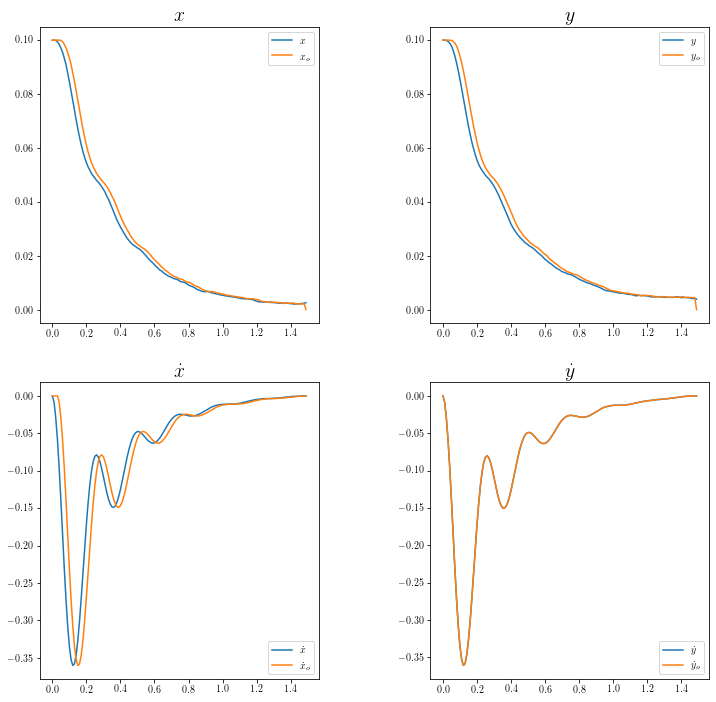

In [139]:
ss = my_sys(A,B,dt,'RK4')
ss.add_feedback(QN,R,N)
ss.add_observer()
ss.add_delay(3)
time_vec,X,Y,Xhat = ss.simulate()
visualize(time_vec,X,Y,Xhat)